## Open notebook in: 
| Colab                                 | Gradient                                                                                                                                         |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH04/ch04_machine_translation.ipynb)                                              | [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH04/ch04_machine_translation.ipynb)|             

In [44]:
# Clone repo, if it's not already cloned, to be sure all runs on smoothly
# on Colab, Kaggle or Paperspace
import os

if not os.path.isdir('Transformers-in-Action'):
    !git clone https://github.com/Nicolepcx/Transformers-in-Action.git
else:
    print('Repository already exists. Skipping clone.')


current_path = %pwd
if '/Transformers-in-Action' in current_path:
    new_path = current_path + '/utils'
else:
    new_path = current_path + '/Transformers-in-Action/utils'
%cd $new_path


Cloning into 'Transformers-in-Action'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 264 (delta 55), reused 63 (delta 27), pack-reused 152
Receiving objects: 100% (264/264), 1.78 MiB | 2.80 MiB/s, done.
Resolving deltas: 100% (127/127), done.
[Errno 2] No such file or directory: '/content/Transformers-in-Action/utils/utils'
/content/Transformers-in-Action/utils


# About this notebook

This Jupyter notebook is designed to perform a comprehensive analysis of text classification on the Financial PhraseBank dataset using both traditional machine learning and Transformers. Here are some key points covered in the notebook:

- __Baseline Model with Naive Bayes__: The notebook begins by creating a baseline model using Naive Bayes, a traditional machine learning algorithm frequently used for text classification tasks. This model serves as a benchmark for evaluating the performance of subsequent models.

- __NewsClassifier for Transformer Models__: The notebook then utilizes the NewsClassifier class to evaluate the performance of various Transformer models on the Financial PhraseBank dataset "out-of-the-box" without any fine-tuning. This allows for an understanding of how well these pre-trained models perform on the task right away.

- __Fine-Tuning RoBERTa and ELECTRA Models__: After this, we delve into fine-tuning two specific Transformer models: RoBERTa and ELECTRA. Fine-tuning involves further training these pre-trained models on the Financial PhraseBank dataset. This process allows these models to specialize their already learned knowledge towards the financial text classification task.

- __Evaluation__: Lastly, we evaluate and compare the results from the fine-tuned RoBERTa and ELECTRA models against the baseline Naive Bayes model and the initial out-of-the-box Transformer models' performance. This comparison is performed using a confusion matrix created from a classification report from the `sklearn` library, with a particular focus on the weighted F1-score and accuracy as key performance metrics. This detailed comparison provides insight into how much improvement the fine-tuning process brought about, and the relative strengths and weaknesses of each model for this particular task.




# Install requirements

In [45]:
from requirements import *

In [46]:
install_required_packages_ch05()

Installing chapter 5 requirements...

✅ transformers == 4.26.1 installation completed successfully!

✅ datasets == 2.10.1 installation completed successfully!

✅ evaluate==0.4.0 installation completed successfully!

✅ pyarrow==9.0.0 installation completed successfully!

✅ sentencepiece installation completed successfully!



# Imports

In [47]:
from setup import *
from utils import *
from plotting import *

In [48]:
useGPU()

Have fun with this chapter!🥳


# Allocate enough RAM

Let us try to get a __GPU__ with at least __15GB RAM__ for our notebook.

In [49]:
# crash colab to get more RAM -> uncomment to use
#!kill -9 -1

We can execute the following command `!free -h`  to see if we have enough RAM and `!nvidia-smi` to get more info about our GPU type we got assigned.
If the allocated GPU is too small, the above cell can be used to run the command to crash the notebook hoping to get a better GPU after the crash, since the GPU is randomly allocated.


In [50]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           50Gi       5.7Gi        24Gi        17Mi        20Gi        44Gi
Swap:            0B          0B          0B


In [51]:
!nvidia-smi

Thu Jun  8 09:30:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   4309MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
import torch

if torch.cuda.is_available():
    gpu_device = torch.device('cuda')
    gpu_info = torch.cuda.get_device_properties(gpu_device)
    gpu_memory = gpu_info.total_memory / 1e9  # Convert bytes to gigabytes
    print(f"GPU: {gpu_info.name}, Total Memory: {gpu_memory:.2f} GB")
else:
    print("No GPU detected.")


GPU: Tesla T4, Total Memory: 15.84 GB


# Imports

In [53]:
# Basic imports
import numpy as np  
import pandas as pd
from datasets import load_dataset

# Torch imports
from torch.utils.data import DataLoader, Dataset  

# Transformers imports
from transformers import (EarlyStoppingCallback, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, 
                          BertForSequenceClassification, ElectraTokenizer, ElectraForSequenceClassification, 
                          RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments) 

# Evaluation imports
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import evaluate  # Evaluation script from Hugging Face

# Visualization imports
import matplotlib.pyplot as plt  

# Miscellaneous imports 
import random  
import warnings  

# Suppress warnings related to undefined metrics in classification reports
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Suppress logging messages from the transformers library
import transformers
transformers.logging.set_verbosity(transformers.logging.ERROR)


In [54]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## Set seed function

The `set_seed` function sets the seed for various random number generators used in the notebook to ensure that the results are reproducible. It first sets the seed for `numpy` and `torch`. If a GPU is available, it then sets the seed for all `cuda` operations and ensures that the results are deterministic.

Setting the seed is important when working with random processes in order to ensure that the results are consistent between runs. This is especially important when training machine learning models, as different random seeds can result in different model performance.

In [55]:
set_seed()

In [56]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Sentiment classification on financial phrasebank dataset

## Load dataset

In [57]:
# Load the Financial Phrasebank dataset using the Hugging Face Datasets library
financial_dataset = load_dataset('financial_phrasebank', 'sentences_allagree')

  0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
financial_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [59]:
# Convert the dataset to a Pandas dataframe for easier manipulation
df = pd.DataFrame(financial_dataset['train'])

# Split the dataset into train, validation, and test sets
#train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [60]:
df.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2


In [61]:
df.label.unique()

array([1, 2, 0])

## Plot data distribution

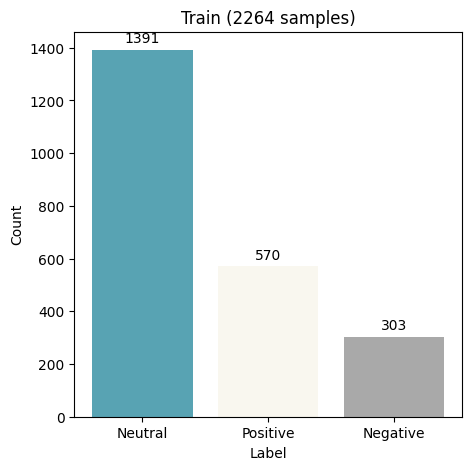

In [62]:
label_map = {
    0: 'Negative',
    1: 'Neutral',
    2: 'Positive',
}

datasets = [df]
dataset_names = ["Train"]

plot_dataset_distribution(datasets, dataset_names, label_map=label_map)


## Undersample dataset

In [63]:
# Undersample the neutral class to 800 samples
neutral_df = df[df['label'] == 1].sample(n=800, random_state=42)
positive_df = df[df['label'] == 2]
negative_df = df[df['label'] == 0]

# Combine the undersampled classes into a new balanced dataset
balanced_df = pd.concat([neutral_df, positive_df, negative_df])

### Plot distribution after undersampling

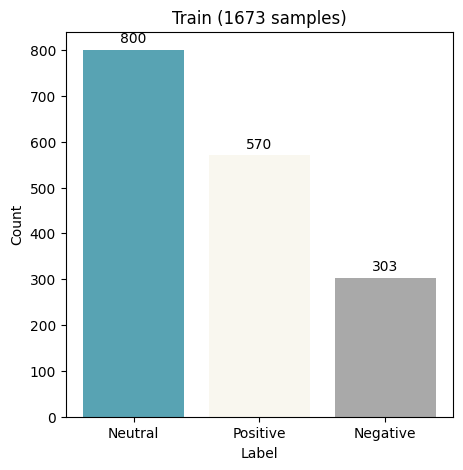

In [64]:
# Plot the label distribution
datasets = [balanced_df]

plot_dataset_distribution(datasets, dataset_names, label_map=label_map)


In [65]:
# Split the balanced dataset into train, validation, and test sets
train_df, test_val_df = train_test_split(balanced_df, test_size=0.25, random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.4, random_state=42)

In [66]:
print(train_df.shape) # 75% = 1254.75
print(val_df.shape) # 15% = 250.95
print(test_df.shape) # 10% = 167.3

(1254, 2)
(251, 2)
(168, 2)


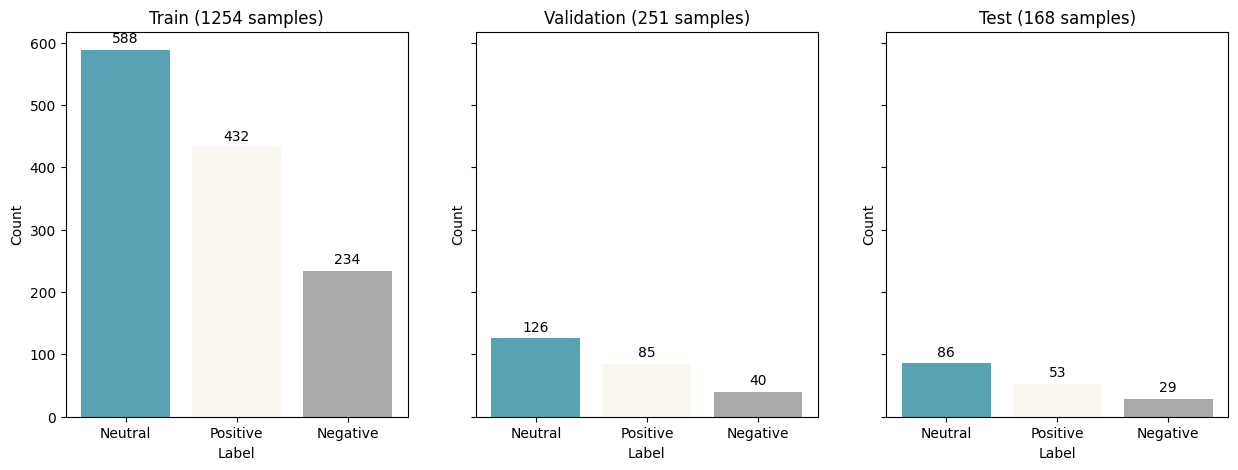

In [67]:
datasets = [train_df, val_df, test_df]
dataset_names = ["Train", "Validation", "Test"]
plot_dataset_distribution(datasets, dataset_names, label_map=label_map)

# Using Naïve Bayes classifier as baseline

Naive Bayes methods are a set of supervised learning algorithms often used for text classification, spam detection, and other similar tasks. These algorithms are based on applying Bayes' theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable.

Bayes' theorem states the following relationship, given class variable \(y\) and dependent feature vector \(x_1\) through \(x_n\):

$$
P(y | x_1, \ldots, x_n) = \frac{P(y) P(x_1, \ldots, x_n | y)}{P(x_1, \ldots, x_n)}
$$

Using the naive conditional independence assumption:

$$
P(x_i | y, x_1, \ldots, x_{i-1}, x_{i+1}, \ldots, x_n) = P(x_i | y),
$$

for all \(i\), this relationship is simplified to:

$$
P(y | x_1, \ldots, x_n) = \frac{P(y) \prod_{i=1}^n P(x_i | y)}{P(x_1, \ldots, x_n)}
$$

Now let's consider the case where the feature vector consists of words $(w_1, w_2, w_3, \dots, w_n)$. The formula for the Naive Bayes method becomes:

\begin{align*}
\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(y \mid w_1, w_2, w_3, \dots, w_n\right) &=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } \frac{P\left(w_1, w_2, w_3, \dots, w_n \mid y\right) \cdot P(y)}{P\left(w_1, w_2, w_3, \dots, w_n\right)} \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(w_1, w_2, w_3, \dots, w_n \mid y\right) \cdot P(y) \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(w_1 \mid y\right) \cdot \prod_{i=2}^n P\left(w_i \mid w_1, \dots, w_{i-1}, y\right) \cdot P(y) \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } \prod_{i=1}^n P\left(w_i \mid y\right) \cdot P(y)
\end{align*}

In the second line, we remove the denominator $(P\left(w_1, w_2, w_3, \dots, w_n\right))$ as it's constant given the input. In the third line, we apply the chain rule of probability. Finally, in the fourth line, we use the naive conditional independence assumption to simplify the product of conditional probabilities.



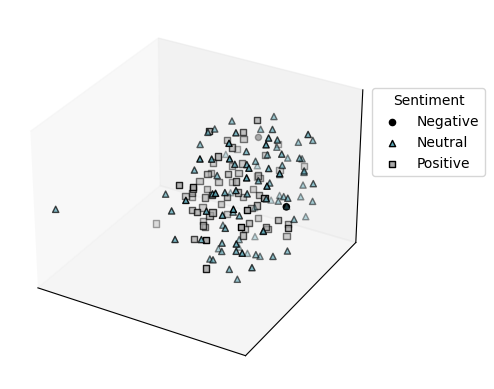

In [68]:
plot_tsne_3d(nb_pipeline, test_df, test_predictions)

             Accuracy  F1 Score  Negative F1  Neutral F1  Positive F1
Model
Naive Bayes  0.720238  0.671115     0.129032    0.863388     0.655738
Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.07      0.13        29
     Neutral       0.81      0.92      0.86        86
    Positive       0.58      0.75      0.66        53

    accuracy                           0.72       168
   macro avg       0.80      0.58      0.55       168
weighted avg       0.77      0.72      0.67       168



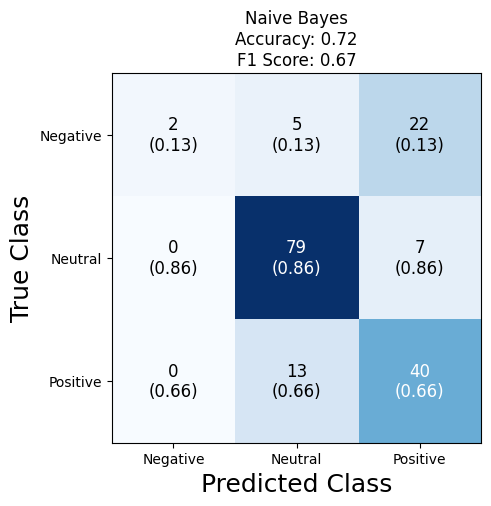

In [69]:
# Call the function for Naive Bayes
bayes_params = {
    "true_labels": test_df["label"],
    "pred_labels": test_predictions,
    "target_names": ["Negative", "Neutral", "Positive"],
    "model_name": "Naive Bayes"
}

evaluation_df_bayes = create_evaluation_df_and_plot(**bayes_params)


# Evaluate different transformer models


The `NewsClassifier` class is for evaluating multiple models on a news classification task. Its primary purpose is to streamline the process of model evaluation, providing quantitative and visual feedback on the performance of each model.

### Attributes

- `test_set`: This is the test dataset used for evaluating the models. It's expected to include 'sentence' and 'label' columns.

- `models`: A dictionary of models to be evaluated. The keys are the model names and the values are the model checkpoint paths.

- `target_names`: A list of class names that correspond to the labels in the 'label' column of the test dataset.

- `num_examples` (optional): The number of examples to use from the test set for evaluation. The default is 100.

- `seed_value` (optional): The seed value for random operations in numpy and torch. This ensures reproducibility. The default is 0.

### Methods

- `set_seed(seed_value=42)`: A static method that sets the seed for numpy, torch, and cudnn to ensure the reproducibility of results.

- `evaluate_models(num_columns=3, figsize=(15, 10))`: This method evaluates all the models on the test set and provides a summary of the results. This includes the accuracy, F1 score, and a confusion matrix for each model. The results are also plotted for visual comparison between models.

### Usage

This class is useful for comparing and selecting the best model for a given news classification task. It visualizes the performance of each model in a clear and concise manner, providing insights not only into the overall accuracy of the models but also into their performance on individual classes. This can help identify models that perform exceptionally well or poorly on specific classes, facilitating the selection of the most appropriate model for the task at hand.

In [70]:
class NewsClassifier:
    def __init__(self, test_set, models, target_names, num_examples=100, seed_value=0):
        self.set_seed(seed_value)
        self.test_set = test_set
        self.models = models
        self.target_names = target_names
        self.num_examples = num_examples

    @staticmethod
    def set_seed(seed_value=42):
        np.random.seed(seed_value)
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def evaluate_models(self, num_columns=3, figsize=(15, 10)):
        evaluation_results = []

        num_models = len(self.models)
        num_rows = (num_models + num_columns - 1) // num_columns

        fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize, sharey=True)
        fig.subplots_adjust(wspace=0.5, hspace=0.5)
        check = u'\u2705'

        for idx, (model_name, model_checkpoint) in enumerate(self.models.items()):
            print(f"{check} Evaluating {model_name}...")

            tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
            model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

            test_texts = self.test_set["sentence"].tolist()[:self.num_examples]
            test_true_labels = self.test_set["label"].tolist()[:self.num_examples]

            test_inputs = tokenizer(test_texts, return_tensors="pt", padding=True, truncation=True)
            with torch.no_grad():
                logits = model(**test_inputs).logits
            test_pred_labels = np.argmax(logits.numpy(), axis=1)

            accuracy = accuracy_score(test_true_labels, test_pred_labels)
            f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')
            report = classification_report(test_true_labels, test_pred_labels, target_names=self.target_names, output_dict=True, digits=4)

            evaluation_results.append({
                "Model": model_name,
                "Accuracy": accuracy,
                "F1 Score": f1,
                "Negative F1": report["Negative"]["f1-score"],
                "Neutral F1": report["Neutral"]["f1-score"],
                "Positive F1": report["Positive"]["f1-score"],
            })

            ax = axes[idx // num_columns, idx % num_columns]
            conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
            im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.set_title(f"{model_name}\nAccuracy: {accuracy:.4f}\nF1 Score: {f1:.4f}")
            tick_marks = np.arange(3)
            ax.set_xticks(tick_marks)
            ax.set_yticks(tick_marks)
            ax.set_xticklabels(self.target_names)
            ax.set_yticklabels(self.target_names)

            # Display F1 scores in the confusion matrix
            for i in range(conf_matrix.shape[0]):
                for j in range(conf_matrix.shape[1]):
                    text_color = "white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black"
                    ax.text(j, i, f"{conf_matrix[i, j]}\n({report[self.target_names[i]]['f1-score']:.4f})",
                            ha="center", va="center", color=text_color, fontsize=10)
          
        for idx in range(num_models, num_rows * num_columns):
            axes[idx // num_columns, idx % num_columns].axis("off")

        evaluation_df = pd.DataFrame(evaluation_results)
        evaluation_df.set_index("Model", inplace=True)

        print(evaluation_df)
        plt.show()
        return evaluation_df


✅ Evaluating BERT...
✅ Evaluating RoBERTa...
✅ Evaluating DistilBERT...
✅ Evaluating DeBERTa...
✅ Evaluating ALBERT...
✅ Evaluating ELECTRA...
            Accuracy  F1 Score  Negative F1  Neutral F1  Positive F1
Model
BERT            0.55  0.512865     0.000000    0.623853     0.538462
RoBERTa         0.52  0.355789     0.000000    0.684211     0.000000
DistilBERT      0.13  0.029912     0.230088    0.000000     0.000000
DeBERTa         0.35  0.181481     0.000000    0.000000     0.518519
ALBERT          0.32  0.190609     0.173913    0.000000     0.480000
ELECTRA         0.23  0.207854     0.168675    0.037037     0.476190


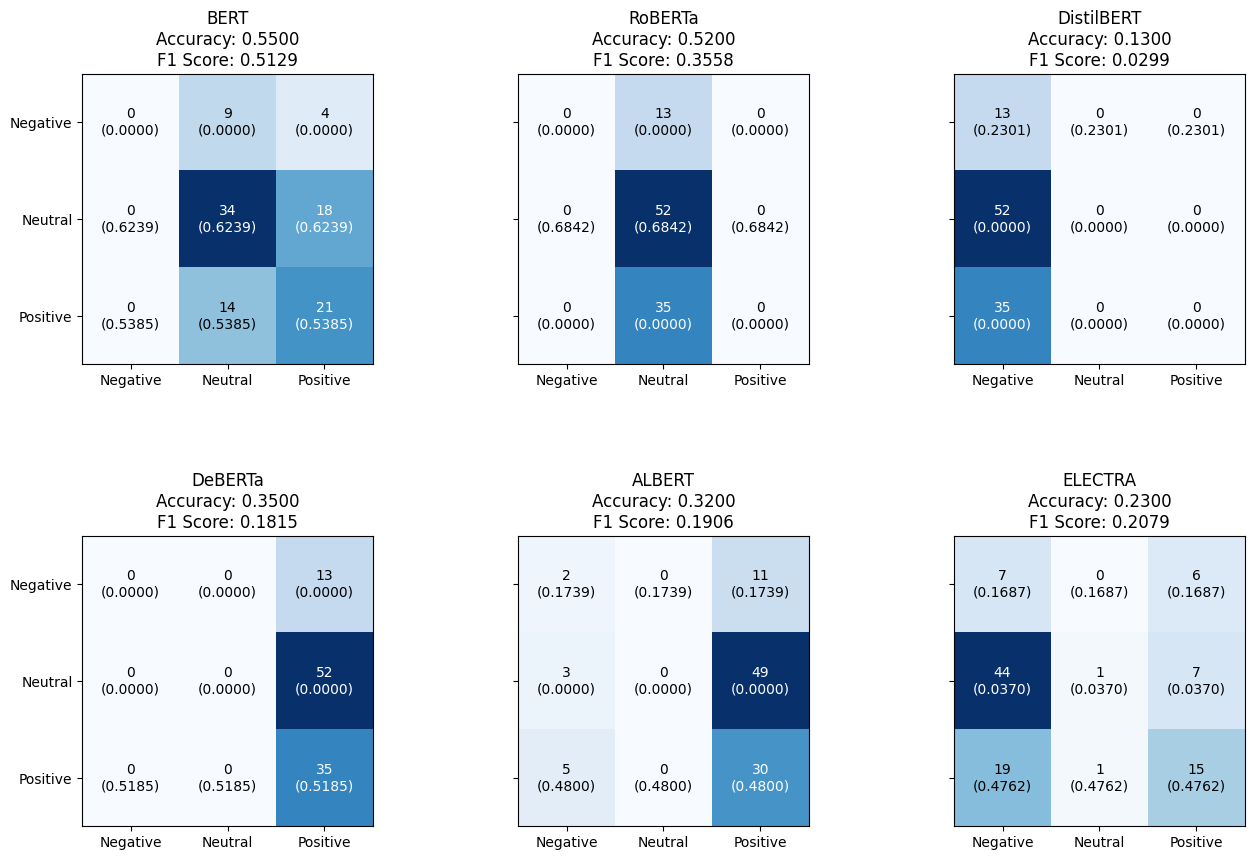

In [71]:
models = {
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "DistilBERT": "distilbert-base-uncased",
    "DeBERTa": "microsoft/deberta-base",
    "ALBERT": "albert-base-v2",
    "ELECTRA": "google/electra-base-discriminator",
}

financial_target_names = ['Negative', 'Neutral', 'Positive']

news_classifier_params = {
    'test_set': test_df,
    'models': models,
    'target_names': financial_target_names,
    'num_examples': 100,
    'seed_value': 0
}

financial_classifier = NewsClassifier(**news_classifier_params)

evaluation_df_financial_phrasebank_before = financial_classifier.evaluate_models(num_columns=3, figsize=(15, 10))

In [72]:
# Create the TfidfVectorizer and MultinomialNB pipeline
nb_pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Train the model
nb_pipeline.fit(train_df["sentence"], train_df["label"])

# Make predictions on the test dataset
test_predictions = nb_pipeline.predict(test_df["sentence"])


## Prepare data

In [73]:
# Define the Financial Phrasebank dataset class
class FinancialPhrasebankDataset(Dataset):
    """
    This class allows to transform text data into a format that is suitable for 
    training transformer-based models, such as BERT.
    It inherits from PyTorch's Dataset class, making it compatible with PyTorch's 
    DataLoader for efficient data loading.

    Attributes:
    data : DataFrame
    The dataset containing sentences and their corresponding labels.
    tokenizer : transformers.PreTrainedTokenizer
    The tokenizer corresponding to the transformer model to be used.
    It will be used to convert text into tokens that the model can understand.
    max_length : int
    The maximum length of the sequences. Longer sequences will be truncated, and shorter ones will be padded.

    Methods:
    len()
    Returns the number of examples in the dataset.
    getitem(index)
    Transforms the sentence at the given index in the dataset into a format suitable for transformer models.
    It returns a dictionary containing the input_ids, attention_mask, and the label for the given sentence.
    
    """
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['sentence']
        label = self.data.iloc[index]['label']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Fine-tune RoBERTa

In this section of the Jupyter notebook, we are setting up a pipeline for training a text classification model using the RoBERTa model from Hugging Face's transformers library. The task is to perform sentiment analysis on financial texts.

First, we load the RoBERTa tokenizer and model. We are using the `roberta-base` version of the model, which is a smaller and faster variant that still delivers good results. The model is a sequence classification model, which is suitable for our task of text classification. We set the number of labels to 3, indicating that we are dealing with a three-class classification problem.

Next, we define the maximum sequence length and batch size. The sequence length is the maximum number of tokens that the model can handle, and the batch size is the number of examples to process at once during training. These are hyperparameters that can be tuned to optimize performance.

We then create Dataset objects for the training, validation, and test sets using the FinancialPhrasebankDataset class we defined earlier. These Dataset objects will be used to feed data into the model during training and evaluation.

The EarlyStoppingCallback is set up to monitor the validation loss during training and stop the training process if it doesn't see significant improvement for 10 consecutive epochs. This helps to prevent overfitting.

The TrainingArguments class is used to set various parameters for the training process, such as the number of epochs, the learning rate, and the batch size. We also specify that we want to save the model that achieves the best performance on the validation set.

Finally, we initialize a Trainer object with our model, the training arguments, the training and validation datasets, and the compute_metrics function for evaluating performance during training. We also add the early stopping callback to the Trainer. The Trainer is then used to train the model. After training, the model that achieved the best performance on the validation set is loaded, ready for evaluation on the test set.

In [74]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define the RoBERTa model with `ignore_mismatched_sizes=True`
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3, ignore_mismatched_sizes=True)

In [75]:
# Define the maximum sequence length and batch size
max_length = 128
batch_size = 16

# Create the training, validation, and test datasets
train_dataset = FinancialPhrasebankDataset(train_df, tokenizer, max_length)
val_dataset = FinancialPhrasebankDataset(val_df, tokenizer, max_length)
test_dataset = FinancialPhrasebankDataset(test_df, tokenizer, max_length)

In [76]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Stop training if the metric doesn't improve for 10 epochs
    early_stopping_threshold=2e-5,  # Minimum change in the monitored metric to be considered as an improvement
)

In [77]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=batch_size,
    save_strategy="epoch",  
    save_total_limit=2,
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    weight_decay=0.01,
    logging_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,  # Load the best model at the end of training
)



# Initialize the trainer with the compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  
    callbacks=[early_stopping_callback]
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1254
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 395
  Number of trainable parameters = 124647939
***** Running Evaluation *****
  Num examples = 251
  Batch size = 8


{'loss': 0.6087, 'learning_rate': 2.4e-05, 'epoch': 1.0}


Saving model checkpoint to ./results/checkpoint-79
Configuration saved in ./results/checkpoint-79/config.json


{'eval_loss': 0.15329402685165405, 'eval_accuracy': 0.9561752988047809, 'eval_runtime': 2.1577, 'eval_samples_per_second': 116.326, 'eval_steps_per_second': 14.83, 'epoch': 1.0}


Model weights saved in ./results/checkpoint-79/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-237] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 251
  Batch size = 8


{'loss': 0.1224, 'learning_rate': 1.8e-05, 'epoch': 2.0}


Saving model checkpoint to ./results/checkpoint-158
Configuration saved in ./results/checkpoint-158/config.json


{'eval_loss': 0.23232971131801605, 'eval_accuracy': 0.952191235059761, 'eval_runtime': 2.051, 'eval_samples_per_second': 122.377, 'eval_steps_per_second': 15.602, 'epoch': 2.0}


Model weights saved in ./results/checkpoint-158/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-395] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 251
  Batch size = 8


{'loss': 0.0584, 'learning_rate': 1.2e-05, 'epoch': 3.0}


Saving model checkpoint to ./results/checkpoint-237
Configuration saved in ./results/checkpoint-237/config.json


{'eval_loss': 0.1561160683631897, 'eval_accuracy': 0.9641434262948207, 'eval_runtime': 2.0487, 'eval_samples_per_second': 122.518, 'eval_steps_per_second': 15.62, 'epoch': 3.0}


Model weights saved in ./results/checkpoint-237/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-158] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 251
  Batch size = 8


{'loss': 0.0341, 'learning_rate': 6e-06, 'epoch': 4.0}


Saving model checkpoint to ./results/checkpoint-316
Configuration saved in ./results/checkpoint-316/config.json


{'eval_loss': 0.14981137216091156, 'eval_accuracy': 0.9681274900398407, 'eval_runtime': 2.0298, 'eval_samples_per_second': 123.656, 'eval_steps_per_second': 15.765, 'epoch': 4.0}


Model weights saved in ./results/checkpoint-316/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-79] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 251
  Batch size = 8


{'loss': 0.012, 'learning_rate': 0.0, 'epoch': 5.0}


Saving model checkpoint to ./results/checkpoint-395
Configuration saved in ./results/checkpoint-395/config.json


{'eval_loss': 0.14422345161437988, 'eval_accuracy': 0.9721115537848606, 'eval_runtime': 2.0395, 'eval_samples_per_second': 123.071, 'eval_steps_per_second': 15.69, 'epoch': 5.0}


Model weights saved in ./results/checkpoint-395/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-237] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-395 (score: 0.14422345161437988).


{'train_runtime': 184.1924, 'train_samples_per_second': 34.04, 'train_steps_per_second': 2.144, 'train_loss': 0.16711903282358676, 'epoch': 5.0}


TrainOutput(global_step=395, training_loss=0.16711903282358676, metrics={'train_runtime': 184.1924, 'train_samples_per_second': 34.04, 'train_steps_per_second': 2.144, 'train_loss': 0.16711903282358676, 'epoch': 5.0})

## Save fine-tuned model

In [78]:
# Save the fine-tuned model
model.save_pretrained("fine_tuned_roberta")

Configuration saved in fine_tuned_roberta/config.json
Model weights saved in fine_tuned_roberta/pytorch_model.bin


## Fine-tune ELECTRA

In this section we fine-tune our `ELECTRA` model on the Financial Phrasebank, following the same appraoch as with our `RoBERTa` model. 

In [79]:
# Empty cache
torch.cuda.empty_cache()


In [80]:
# Load the ELECTRA tokenizer
tokenizer = ElectraTokenizer.from_pretrained("google/electra-base-discriminator")

# Define the ELECTRA model
model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels=3)


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--google--electra-base-discriminator/snapshots/1b48ef100dac4676d84125a8a7b7ab7c51e00386/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--electra-base-discriminator/snapshots/1b48ef100dac4676d84125a8a7b7ab7c51e00386/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--electra-base-discriminator/snapshots/1b48ef100dac4676d84125a8a7b7ab7c51e00386/config.json
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "i

In [81]:
# Define the maximum sequence length and batch size
max_length = 128
batch_size = 16

# Create the training, validation, and test datasets
train_dataset = FinancialPhrasebankDataset(train_df, tokenizer, max_length)
val_dataset = FinancialPhrasebankDataset(val_df, tokenizer, max_length)
test_dataset = FinancialPhrasebankDataset(test_df, tokenizer, max_length)

In [82]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=batch_size,
    save_strategy="epoch",  
    save_total_limit=2,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,  # Load the best model at the end of training
)


# Initialize the trainer with the compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  
    callbacks=[early_stopping_callback]
)


# Train the model
trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1254
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 395
  Number of trainable parameters = 109484547


Epoch,Training Loss,Validation Loss,Accuracy
1,0.552400,0.215294,0.948207
2,0.123500,0.257699,0.940239
3,0.049100,0.113062,0.976096
4,0.024000,0.189915,0.960159
5,0.022100,0.269889,0.948207


***** Running Evaluation *****
  Num examples = 251
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-79
Configuration saved in ./results/checkpoint-79/config.json
Model weights saved in ./results/checkpoint-79/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-316] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 251
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-158
Configuration saved in ./results/checkpoint-158/config.json
Model weights saved in ./results/checkpoint-158/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-395] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 251
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-237
Configuration saved in ./results/checkpoint-237/config.json
Model weights saved in ./results/checkpoint-237/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-79] due to args.save_total_limit
***** Running Evaluatio

TrainOutput(global_step=395, training_loss=0.15422650530368467, metrics={'train_runtime': 177.5564, 'train_samples_per_second': 35.313, 'train_steps_per_second': 2.225, 'total_flos': 412430282288640.0, 'train_loss': 0.15422650530368467, 'epoch': 5.0})

In [83]:
# Save the fine-tuned model
model.save_pretrained("fine_tuned_electra")

Configuration saved in fine_tuned_electra/config.json
Model weights saved in fine_tuned_electra/pytorch_model.bin


## Evaluate fine-tuned models

loading configuration file fine_tuned_roberta/config.json
Model config RobertaConfig {
  "_name_or_path": "fine_tuned_roberta",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights fil

                    Accuracy  F1 Score  Negative F1  Neutral F1
Positive F1
Model
Fine-tuned RoBERTa  0.982143  0.982207     0.983051    0.988235
0.971963
Classification Report:
              precision    recall  f1-score   support

    Negative     0.9667    1.0000    0.9831        29
     Neutral     1.0000    0.9767    0.9882        86
    Positive     0.9630    0.9811    0.9720        53

    accuracy                         0.9821       168
   macro avg     0.9765    0.9860    0.9811       168
weighted avg     0.9826    0.9821    0.9822       168



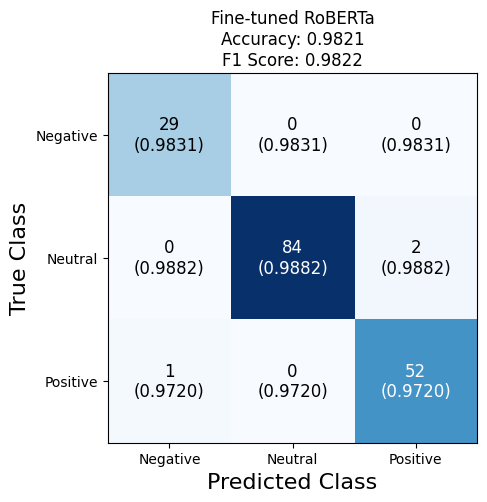

In [84]:
model = AutoModelForSequenceClassification.from_pretrained("fine_tuned_roberta", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
evaluation_df_financial_phrasebank_roberta = evaluate_model(
    model, tokenizer, test_df, ["Negative", "Neutral", "Positive"], model_name="Fine-tuned RoBERTa", is_dataframe=True)


loading configuration file fine_tuned_electra/config.json
Model config ElectraConfig {
  "_name_or_path": "fine_tuned_electra",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version"

                    Accuracy  F1 Score  Negative F1  Neutral F1
Positive F1
Model
Fine-tuned ELECTRA  0.988095  0.988095     0.965517         1.0
0.981132
Classification Report:
              precision    recall  f1-score   support

    Negative     0.9655    0.9655    0.9655        29
     Neutral     1.0000    1.0000    1.0000        86
    Positive     0.9811    0.9811    0.9811        53

    accuracy                         0.9881       168
   macro avg     0.9822    0.9822    0.9822       168
weighted avg     0.9881    0.9881    0.9881       168



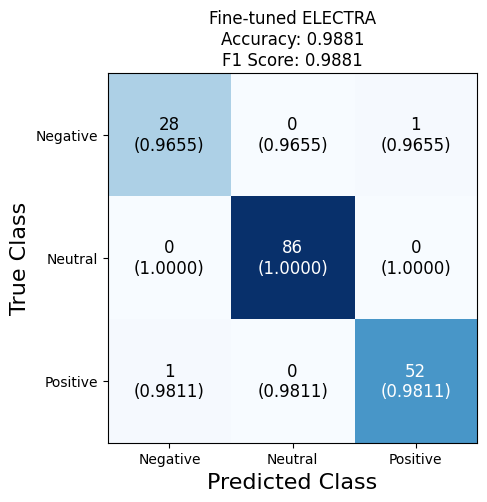

In [85]:
model = AutoModelForSequenceClassification.from_pretrained("fine_tuned_electra", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')
evaluation_df_financial_phrasebank_electra = evaluate_model(
    model, tokenizer, test_df, ["Negative", "Neutral", "Positive"], model_name="Fine-tuned ELECTRA", is_dataframe=True)

## Concat dataframes for evaluation

In [86]:
evaluation_df_financial_phrasebank_all = evaluation_df_financial_phrasebank_before.append(evaluation_df_financial_phrasebank_roberta) 
evaluation_df_financial_phrasebank_all = evaluation_df_financial_phrasebank_all.append(evaluation_df_financial_phrasebank_electra)
evaluation_df_financial_phrasebank_all = evaluation_df_financial_phrasebank_all.append(evaluation_df_bayes)
evaluation_df_financial_phrasebank_all

<ipython-input-86-066f453a892c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df_financial_phrasebank_all = evaluation_df_financial_phrasebank_before.append(evaluation_df_financial_phrasebank_roberta)
<ipython-input-86-066f453a892c>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df_financial_phrasebank_all = evaluation_df_financial_phrasebank_all.append(evaluation_df_financial_phrasebank_electra)
<ipython-input-86-066f453a892c>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df_financial_phrasebank_all = evaluation_df_financial_phrasebank_all.append(evaluation_df_bayes)


,Accuracy,F1 Score,Negative F1,Neutral F1,Positive F1
Model,,,,,
BERT,0.550000,0.512865,0.000000,0.623853,0.538462
RoBERTa,0.520000,0.355789,0.000000,0.684211,0.000000
DistilBERT,0.130000,0.029912,0.230088,0.000000,0.000000
DeBERTa,0.350000,0.181481,0.000000,0.000000,0.518519
ALBERT,0.320000,0.190609,0.173913,0.000000,0.480000
ELECTRA,0.230000,0.207854,0.168675,0.037037,0.476190
Fine-tuned RoBERTa,0.982143,0.982207,0.983051,0.988235,0.971963
Fine-tuned ELECTRA,0.988095,0.988095,0.965517,1.000000,0.981132
Naive Bayes,0.720238,0.671115,0.129032,0.863388,0.655738
